In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
import pandas as pd

import nltk
nltk.download('punkt')

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from os import path

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# ***English*: Data Loader**

X_train, X_val, X_test: list of *input text data*

Y_train, Y_val, Y_test: list of one-hot encoded *labels*

code2idx: dict of the form *ICD code : index in label* 

ID: list of *article Ids*


**NOTE**: Test data is fixed using random seed

---




In [7]:
df_train = pd.read_csv('drive/MyDrive/CodiEsp/train/trainD.tsv', sep = '\t', header = None)
df_train.rename(columns = {0:"Id", 1:"ICD10"}, inplace = True)
print("Training Data:")
display(df_train.head())

print("\n\nValidation Data:")
df_val = pd.read_csv('drive/MyDrive/CodiEsp/dev/devD.tsv', sep = '\t', header = None)
df_val.rename(columns = {0:"Id", 1:"ICD10"}, inplace = True)
display(df_val.head())

print("\n\nTest Data:")
df_test = pd.read_csv('drive/MyDrive/CodiEsp/test/testD.tsv', sep = '\t', header = None)
df_test.rename(columns = {0:"Id", 1:"ICD10"}, inplace = True)
display(df_test.head())

df = pd.concat([df_train, df_val, df_test])

Training Data:


,Id,ICD10
0,S0004-06142005000700014-1,n44.8
1,S0004-06142005000700014-1,z20.818
2,S0004-06142005000700014-1,r60.9
3,S0004-06142005000700014-1,r52
4,S0004-06142005000700014-1,a23.9




Validation Data:


,Id,ICD10
0,S0004-06142005000900016-1,q62.11
1,S0004-06142005000900016-1,n28.89
2,S0004-06142005000900016-1,n39.0
3,S0004-06142005000900016-1,r31.9
4,S0004-06142005000900016-1,n23




Test Data:


,Id,ICD10
0,S0004-06142005000500011-1,s22.49xa
1,S0004-06142005000500011-1,n28.1
2,S0004-06142005000500011-1,r69
3,S0004-06142005000500011-1,f17.210
4,S0004-06142005000500011-1,r31.9


In [8]:
ids = df['Id'].unique()
codes = df['ICD10'].unique()  

print("Number of documents in training data:", len(ids), "\nNumber of ICD10 codes:", len(codes))

Number of documents in training data: 1000 
Number of ICD10 codes: 2557


In [9]:
code2idx = {}
for i in range(len(codes)):
  code2idx[codes[i]] = i

id2label = {}
for i in range(len(ids)):
  id2label[ids[i]] = [0]*len(codes)

for i, data in df.iterrows():
  _id = data[0]
  _code = data[1]
  id2label[_id][code2idx[_code]] = 1

_id2label = [(id, y) for id, y in id2label.items()]
ID, Y = zip(*_id2label)

In [13]:
id2doc = {}

print("Documents processed: ", end = "  ")
for i, _id in enumerate(ids):
  if (path.exists('drive/MyDrive/CodiEsp/train/text_files_en/' + _id + '.txt')):
    with open('drive/MyDrive/CodiEsp/train/text_files_en/' + _id + '.txt', 'r') as f:
      text = f.read().replace('\n', ' ')
  elif (path.exists('drive/MyDrive/CodiEsp/dev/text_files_en/' + _id + '.txt')):
    with open('drive/MyDrive/CodiEsp/dev/text_files_en/' + _id + '.txt', 'r') as f:
      text = f.read().replace('\n', ' ')
  else:
    with open('drive/MyDrive/CodiEsp/test/text_files_en/' + _id + '.txt', 'r') as f:
      text = f.read().replace('\n', ' ')

  if ((i + 1)%50 == 0):
    print(i + 1, end = ' ')

  id2doc[_id] = text

print('\n.. Done!')

Documents processed:   50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000 
.. Done!


In [14]:
tmp = 0
print('For id =', df['Id'].iloc[tmp], '. The text is\n')
display(id2doc[df['Id'].iloc[tmp]])

For id = S0004-06142005000700014-1 . The text is



'We describe the case of a 37-year-old man with a previous active life who complained of osteoarticular pain of variable location in the last month and fever in the last week with peaks (morning and evening) of 40 C. Before the onset of symptoms she was in Extremadura in an endemic region of brucella, taking pasteurized milk and cheese from that cattle. Among the diners appeared several cases of brucellosis. During admission for study of the febrile syndrome with epidemiological history of possible exposure to Brucella presents a picture of right orchiepididymitis. Physical examination revealed: Ta 40.2 C; T.A: 109/68 mmHg; Fc: 105 bpm. She is conscious, oriented, sweating, eupneic, with good nutritional status and hydration. Adenopathy, goiter or jugular vein engorgement, with symmetrical carotid pulses, is not present in the head and neck. Auscultation cardiac arrhythmia, not murmurs, ropes or extracts. Pulmonary emphysema with vesicular murmur conservation. Abdomen blade, depressibl

In [15]:
X = []
for i, _id in enumerate(ID):
  X.append(id2doc[_id])

In [ ]:
X_tmp, X_test, Y_tmp, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
X_train, X_val, Y_train, Y_val = train_test_split(X_tmp, Y_tmp, test_size = 0.2)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
_X, _Y = ros.fit_sample(np.array(X).reshape(-1, 1), np.array(Y))

_X_tmp, _X_test, _Y_tmp, _Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
_X_train, _X_val, _Y_train, _Y_val = train_test_split(_X_tmp, _Y_tmp, test_size = 0.2)

# ***English*: Data Analysis**

---



In [16]:
class Language:
  ''' Gives token frequency and
      sentence length frequency '''

  def __init__(self, tokenizer):
    self.word2freq = {}
    self.len2freq = {}
    self.tokenizer = tokenizer

  def addSentence(self, doc):
    if (self.tokenizer == 'nltk'):
      tokens = nltk.word_tokenize(doc)

    if (len(tokens) in self.len2freq):
      self.len2freq[len(tokens)] += 1
    else:
      self.len2freq[len(tokens)] = 1
      
    for token in tokens:
      self.addData(token)

  def addData(self, token):
    if (token in self.word2freq):
      self.word2freq[token] += 1
    else:
      self.word2freq[token] = 1

In [17]:
eng = Language('nltk')

for i, data in enumerate(id2doc.items()):
  doc = data[1]
  eng.addSentence(doc)

In [18]:
_dict = [(k, v) for k, v in eng.word2freq.items()]
_dict = sorted(_dict, key = lambda x: x[1], reverse = True)
x, y = zip(*_dict)

Total number of tokens =  21520 



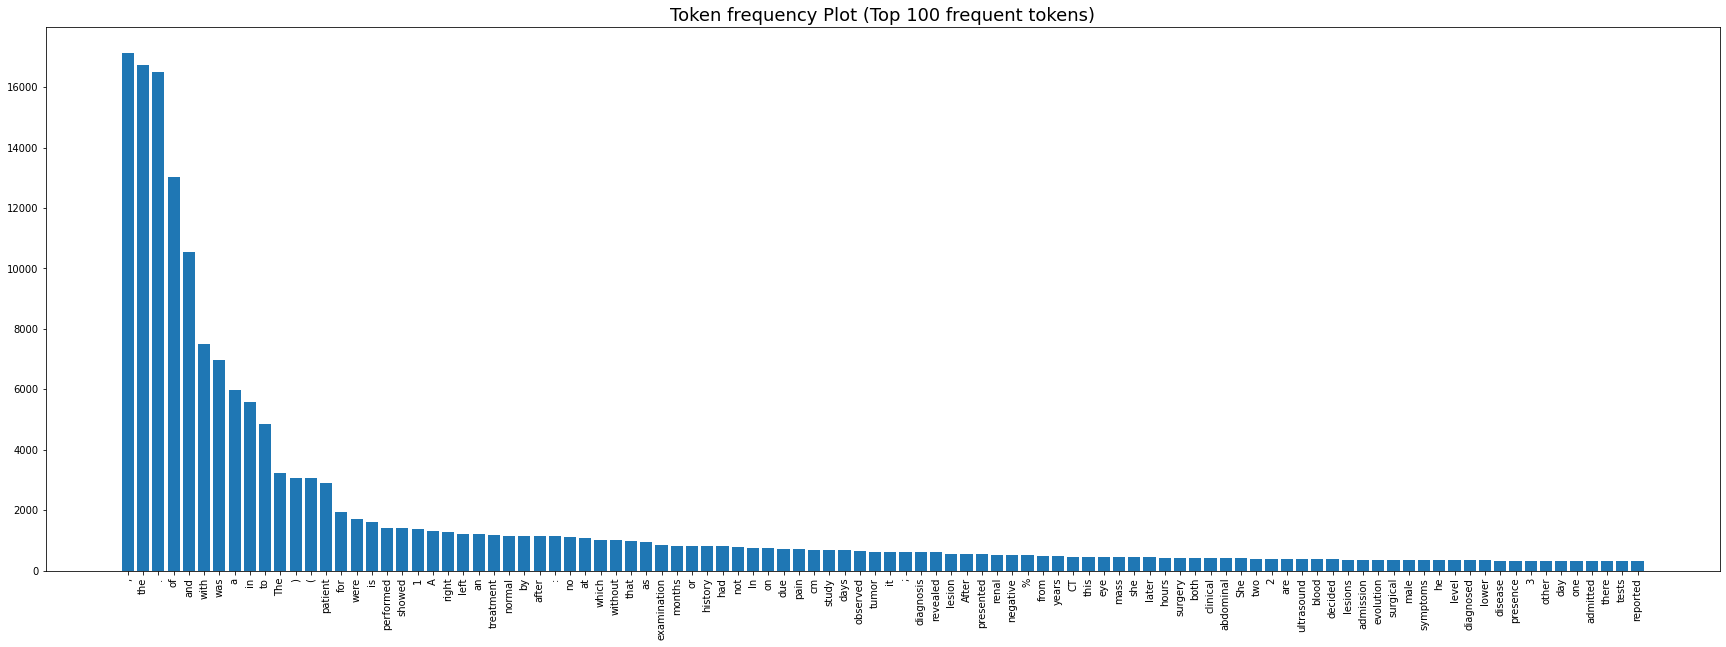

In [19]:
print("Total number of tokens = ", len(_dict), "\n")

plt.figure(figsize = (30, 10))
plt.xticks(rotation = "vertical")
plt.title("Token frequency Plot (Top 100 frequent tokens)", fontsize = 18)
plt.bar(x[:100], y[:100])
plt.show();

In [20]:
_dict = [(k, v) for k, v in eng.len2freq.items()]
_dict = sorted(_dict, key = lambda x: x[0], reverse = False)
x, y = zip(*_dict)

In [22]:
lens = []
for k, v in eng.len2freq.items():
  for i in range(v):
    lens.append(k)

In [24]:
sum(lens) / len(lens)

342.63

In [25]:
x = lens

In [26]:
n = len(x)
x_ord, index = sorted(x), round(0.5 * n)
0.5 * (x_ord[index-1] + x_ord[index])

318.5

In [29]:
mean_ = sum(x) / n
sum((item - mean_)**2 for item in x) / (n - 1)

25961.142242242255

In [ ]:
sqrt()

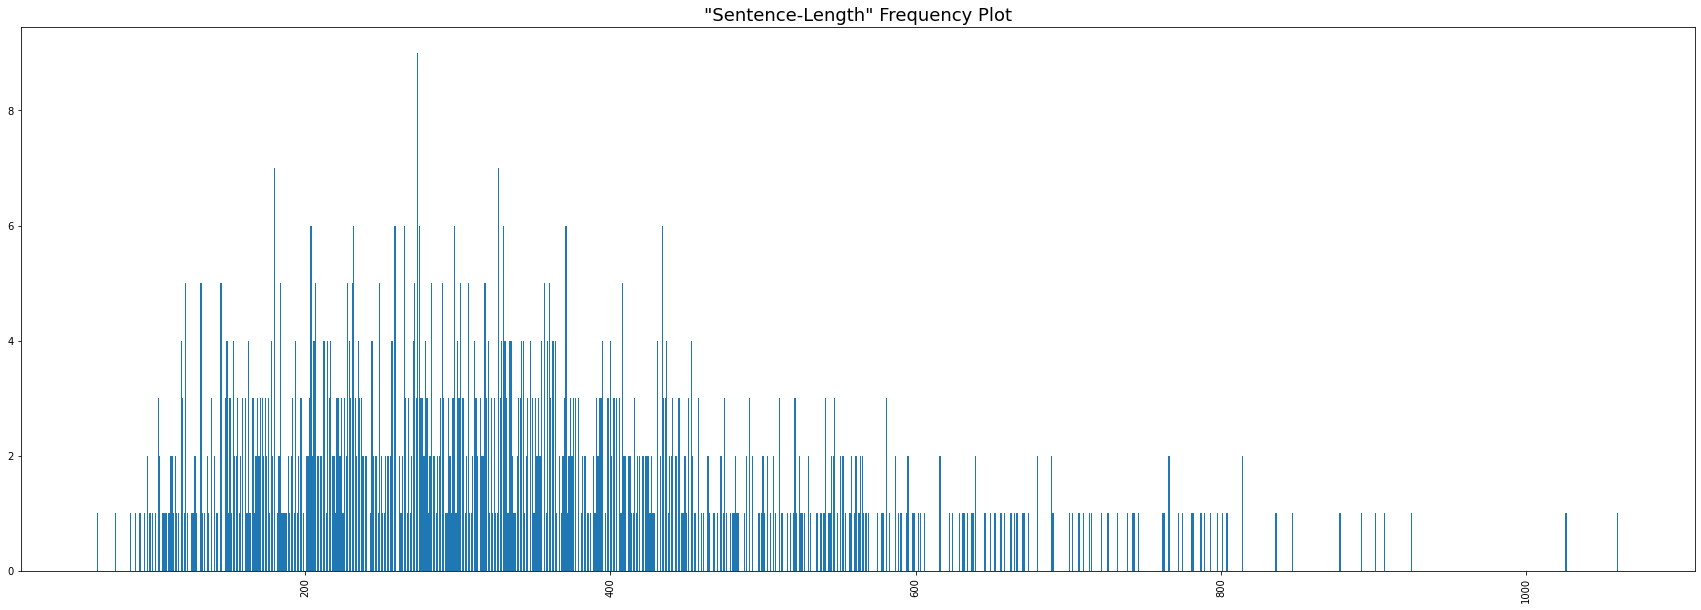

In [ ]:
plt.figure(figsize = (30, 10))
plt.xticks(rotation = "vertical")
plt.title("\"Sentence-Length\" Frequency Plot", fontsize = 18)
plt.bar(x, y)

plt.show();

In [ ]:
p_code = [0]*len(codes)
for label in Y_train:
  for i, code in enumerate(label):
    if (code == 1):
      p_code[i] = 1

not_present = 0
for i, present in enumerate(p_code):
  if (present == 0):
    not_present += 1

print("Number of classes NOT PRESENT in training dataset:", not_present)

Number of classes NOT PRESENT in training dataset 545


# ***English*: Training**
 

*   Feature Extraction:
  * Bag Of Words
  * Term Frequency Inverse Document Frequency
*   Models:
  * Support Vector Classifier
  * Random Forest Classifier
  * AdaBoost Classifier
* Hyper-parameter tuning

---



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss

import numpy as np

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def hamming_score(y_true, y_pred, normalize = True, sample_weight = None):
    ''' Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
        http://stackoverflow.com/q/32239577/395857 '''

    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set(np.where(y_true[i])[0])
        set_pred = set(np.where(y_pred[i])[0])
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def print_score(y_pred, y_t, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_t)))
    print("Hamming score: {}".format(hamming_score(y_pred, y_t)))
    print("---")    

In [ ]:
nb_clf = MultinomialNB()
sgd = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 1e-3, random_state = 42, max_iter = 6, tol = None)
lr = LogisticRegression())
rf = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
scv = SVC()

In [ ]:
def trainModels(x, y, x_t, y_t):
  for classifier in [nb_clf, sgd, lr, rf, scv, ada_clf]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x, y)
    y_pred = clf.predict(x_t)
    print_score(y_pred, y_t, classifier)

In [ ]:
count_vect = CountVectorizer()
count_vect = count_vect.fit(X_tmp)

tfidf_transformer = TfidfVectorizer()
tfidf_transformer = tfidf_transformer.fit(X_tmp)

In [ ]:
trainModels(count_vect.transform(X_train), Y_train, count_vect.transform(X_val), Y_val)

Clf:  MultinomialNB
Hamming loss: 0.0043214704732107935
Hamming score: 0.019511326664266738
---
Clf:  SGDClassifier
Hamming loss: 0.0049472037543996875
Hamming score: 0.06244089071265431
---
Clf:  MultinomialNB
Hamming loss: 0.0043214704732107935
Hamming score: 0.019511326664266738
---
Clf:  RandomForestClassifier
Hamming loss: 0.004265252248728979
Hamming score: 0.00527290962033609
---
Clf:  SVC
Hamming loss: 0.004299472037543997
Hamming score: 0.0006944444444444444
---


In [ ]:
trainModels(tfidf_transformer.transform(X_train), Y_train, tfidf_transformer.transform(X_val), Y_val)

Clf:  MultinomialNB
Hamming loss: 0.004301916308173641
Hamming score: 0.0
---
Clf:  SGDClassifier
Hamming loss: 0.0042236996480250295
Hamming score: 0.024933796410310533
---
Clf:  LogisticRegression
Hamming loss: 0.004301916308173641
Hamming score: 0.0
---
Clf:  MultinomialNB
Hamming loss: 0.004301916308173641
Hamming score: 0.0
---


In [ ]:
count_vect = CountVectorizer()
count_vect = count_vect.fit(_X_tmp)

In [ ]:
trainModels(count_vect.transform(_X_train), _Y_train, count_vect.transform(_X_val), _Y_val)

Clf:  MultinomialNB
Hamming loss: 0.004284806413766132
Hamming score: 0.016437661913335323
---
Clf:  SGDClassifier
Hamming loss: 0.004900762612436449
Hamming score: 0.06511499628534043
---
Clf:  LogisticRegression
Hamming loss: 0.004177258506061791
Hamming score: 0.05689670965685294
---
Clf:  MultinomialNB
Hamming loss: 0.004284806413766132
Hamming score: 0.016437661913335323
---
